In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches as pat
from matplotlib import transforms
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from joblib import load, dump
import re
from scipy.stats import gaussian_kde

# custom code
import figutils

2022-09-20 22:21:58.217705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-09-20 22:21:58.217724: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
plt.style.use('/home/ms7490/scratch/code/scratch/matplotlib/clean.mplstyle')

# Baeza et al.

In [4]:
baeza_et_al = load('./figure_2_extended/baeza_et_al.pkl')
baeza_et_al_titles = ['FAS exon 6'] # ['Baeza et al.']

# Ke et al.

In [5]:
ke_et_al = load('./figure_2_extended/ke_et_al.pkl')
ke_et_al_titles = [f'WT1 exon 5 HexMut{c}' for c in 'CFHI'] # [f'Ke et al. - HexMut{c}' for c in 'CFHI']

# Rosenberg et al.

In [6]:
rosenberg_et_al = load('./figure_2_extended/rosenberg_et_al.pkl')
rosenberg_et_al_titles = ['SMN2 exon 7'] #['Rosenberg et al.']

# Ours

In [35]:
ours = load('./figure_2_extended/ours.pkl')
ours_title = ['']

# Combine data

In [7]:
plot_data = baeza_et_al + ke_et_al + rosenberg_et_al
plot_titles = baeza_et_al_titles + ke_et_al_titles + rosenberg_et_al_titles

# Plot data

In [8]:
def make_numpy(x):
    if not isinstance(x, np.ndarray):
        if isinstance(x, pd.Series) or isinstance(x, pd.DataFrame):
            return x.values
        return np.array(x)
    return x

In [9]:
n_plots = len(plot_data)

In [10]:
plot_titles

['FAS exon 6',
 'WT1 exon 5 HexMutC',
 'WT1 exon 5 HexMutF',
 'WT1 exon 5 HexMutH',
 'WT1 exon 5 HexMutI',
 'SMN2 exon 7']

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


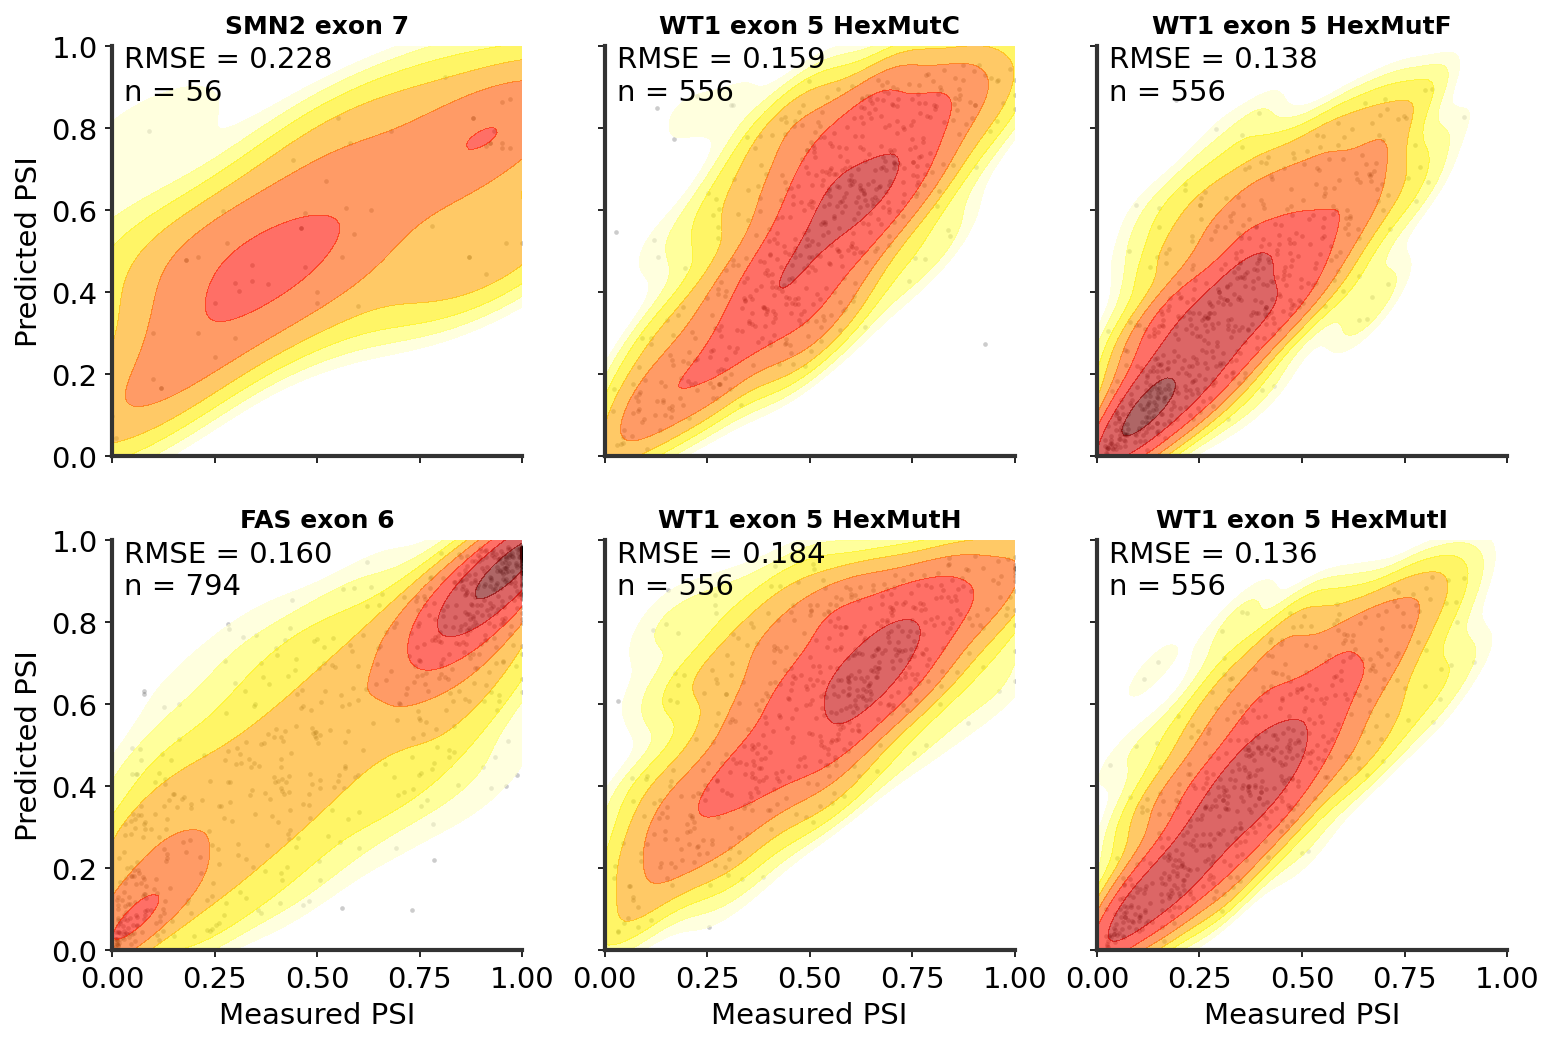

In [11]:
fig, axarr = plt.subplots(2, n_plots//2, figsize=(n_plots*2, 4*2), dpi=150, sharex=True, sharey=True)
# fig, axarr = plt.subplots(1, n_plots, figsize=(n_plots*4, 4), dpi=150, sharex=True, sharey=True)
# fig, axarr = plt.subplots(2, 4, figsize=(n_plots*2, 4*2), dpi=150, sharex=True, sharey=True)
# fig, axarr = plt.subplots(n_plots//2, 2, figsize=(4*2, n_plots*2), dpi=150, sharex=True, sharey=True)

axarr = axarr.flatten()

for i, (m_psi, p_psi), plot_title in zip([3, 1, 2, 4, 5, 0], plot_data, plot_titles):
    # make data numpy array
    m_psi, p_psi = map(make_numpy, [m_psi, p_psi])
    
    # clip data at 1
    m_psi = np.minimum(1, m_psi)
    
    # record RMSE
    rmse = np.sqrt(((m_psi - p_psi) ** 2).mean())
    
    x, y = figutils.subsample_points(m_psi, p_psi, max_points=10000)
    
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    z = kde(xy)
    
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    axarr[i].scatter(x, y, alpha=0.2, s=5, cmap=plt.cm.hot_r, linewidth=0., c='k')
    
    grid_resolution = 100
    A, B = np.meshgrid(np.linspace(0, 1, grid_resolution), np.linspace(0, 1, grid_resolution))
    xygrid = np.vstack([A.flatten(), B.flatten()])
    zgrid = kde(xygrid)
    
    axarr[i].contourf(A, B,
                np.log(zgrid).reshape(*A.shape), 10000, origin='lower',
                cmap=plt.cm.hot_r, alpha=0.6, levels=np.linspace(-2, 3, 10))
    axarr[i].set_title(plot_title, fontsize=12)
    
    if i in [0, 3]:
        axarr[i].set_ylabel(f"Predicted PSI", fontsize=14)
    if i in [3, 4, 5]:
        axarr[i].set_xlabel(f"Measured PSI", fontsize=14)
        
    axarr[i].text(3e-2, 1., f'RMSE = {rmse:.3f}\nn = {m_psi.shape[0]}', ha='left', fontsize=14, va='top')
    # axarr[i].text(0.5, 0.5, f'{i}')

for ax in axarr:
    if not isinstance(ax, float):
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.set(adjustable='box', aspect='equal')

fig.savefig('./figs/model_performance_external_datasets.svg', pad_inches=0.1,
            bbox_inches='tight')
fig.savefig('./figs/model_performance_external_datasets.pdf', pad_inches=0.1,
            bbox_inches='tight')

In [43]:
tuner_data = load('./figure_2_extended/tuner.pkl')

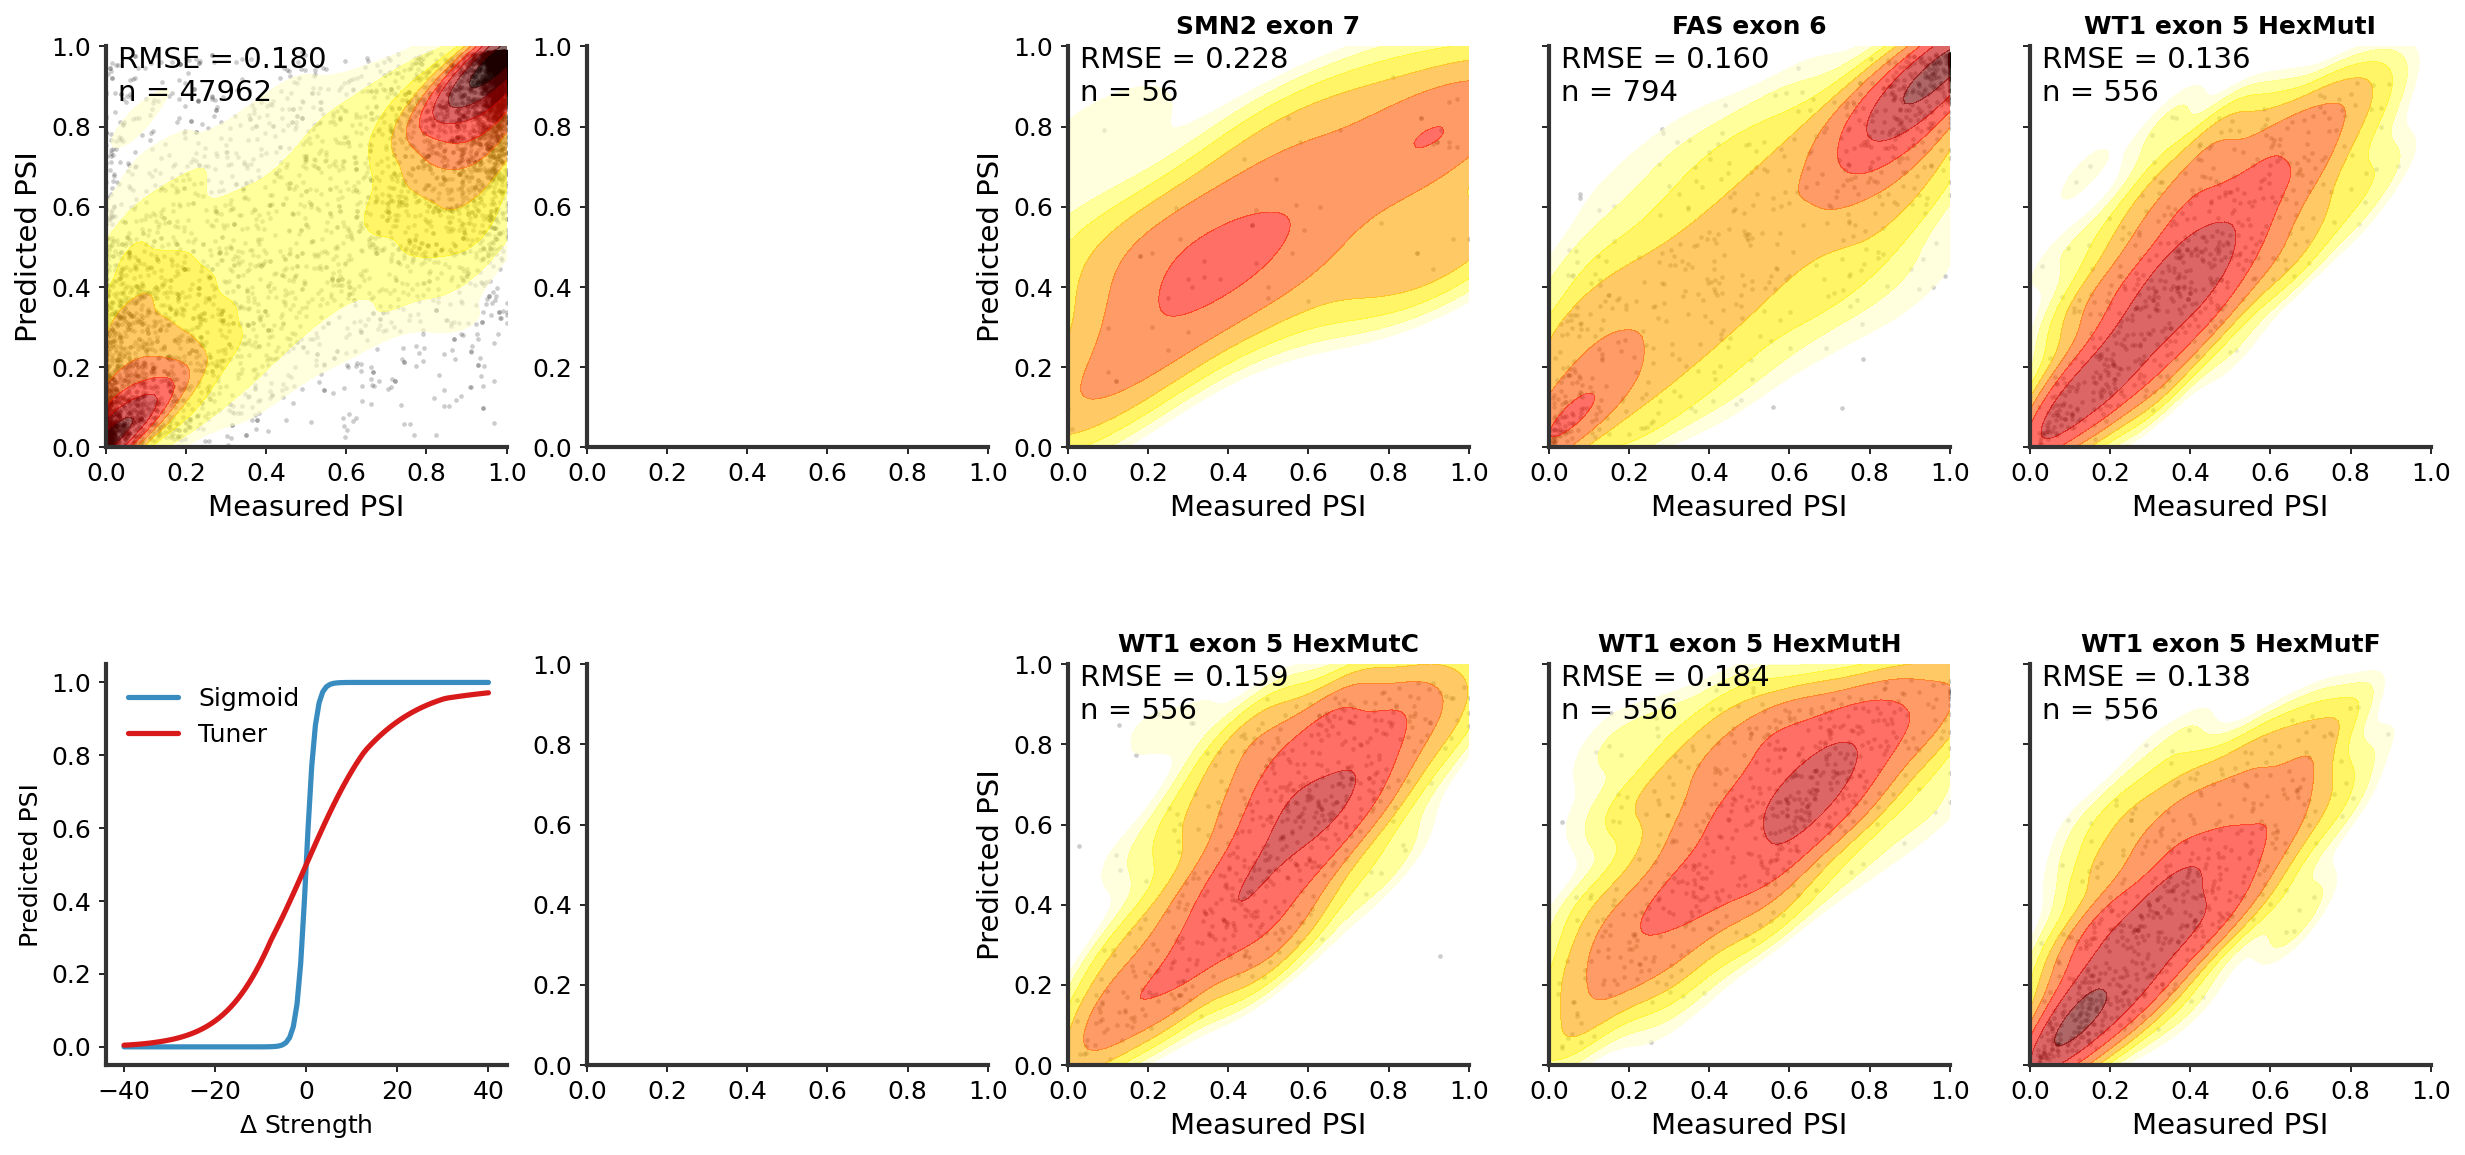

In [55]:
fig, axarr = plt.subplots(2, n_plots//2 + 2, figsize=((n_plots+2)*5//2, 5*2), dpi=150, sharex=False, sharey=False, subplot_kw=dict(box_aspect=1))

axarr = axarr.flatten()

for i, (m_psi, p_psi), plot_title in zip([0] + [7, 3, 4, 8, 9, 2], ours + plot_data, ours_title + plot_titles):
    
    # swap hex mut i and f
    if i == 4:
        i = 9
    elif i == 9:
        i = 4
    elif i == 3:
        i = 7
    elif i == 7:
        i = 3
    
    
    # make data numpy array
    m_psi, p_psi = map(make_numpy, [m_psi, p_psi])
    
    # clip data at 1
    m_psi = np.minimum(1, m_psi)
    
    # record RMSE
    rmse = np.sqrt(((m_psi - p_psi) ** 2).mean())
    
    x, y = figutils.subsample_points(m_psi, p_psi, max_points=10000)
    
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy)
    z = kde(xy)
    
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    axarr[i].scatter(x, y, alpha=0.2, s=5, cmap=plt.cm.hot_r, linewidth=0., c='k')
    
    grid_resolution = 100
    A, B = np.meshgrid(np.linspace(0, 1, grid_resolution), np.linspace(0, 1, grid_resolution))
    xygrid = np.vstack([A.flatten(), B.flatten()])
    zgrid = kde(xygrid)
    
    axarr[i].contourf(A, B,
                np.log(zgrid).reshape(*A.shape), 10000, origin='lower',
                cmap=plt.cm.hot_r, alpha=0.6, levels=np.linspace(-2, 3, 10))
    axarr[i].set_title(plot_title, fontsize=12)
    
    if i in [0, 2, 7, ]:
        axarr[i].set_ylabel(f"Predicted PSI", fontsize=14)
    else:
        axarr[i].yaxis.set_ticklabels([])
    if i in [0, 2, 3, 4, 7, 8, 9]:
        axarr[i].set_xlabel(f"Measured PSI", fontsize=14)
    else:
        axarr[i].xaxis.set_ticklabels([])
        
    axarr[i].text(3e-2, 1., f'RMSE = {rmse:.3f}\nn = {m_psi.shape[0]}', ha='left', fontsize=14, va='top')


axarr[5].plot(tuner_data['sigmoid'][0], tuner_data['sigmoid'][1], label='Sigmoid')
axarr[5].plot(tuner_data['tuner'][0], tuner_data['tuner'][1], label='Tuner')
axarr[5].legend(loc='upper left', frameon=False, fontsize=12)

axarr[5].set_ylabel('Predicted PSI', fontsize=12)
axarr[5].set_xlabel('$\Delta$ Strength', fontsize=12)
# axarr[5].tick_params(axis='both', labelsize=12)

    
for idx, ax in enumerate(axarr):
    if not isinstance(ax, float):
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        if not idx in [5]:
            ax.set(adjustable='box', aspect='equal')
        else:
            pass 

fig.savefig('./figs/model_performance_external_datasets_with_ours.svg', pad_inches=0.1,
            bbox_inches='tight')
fig.savefig('./figs/model_performance_external_datasets_with_ours.pdf', pad_inches=0.1,
            bbox_inches='tight')